## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [22]:
def white_yellow_select(img):
    upper_mask = np.array([255, 255, 0])
    lower_mask = np.array([255, 255, 255])
    return cv2.inRange(img, lower_mask, upper_mask)

def opening(img, kernel_size):
    """Applies erosion and dialation to reduce noise"""
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, (kernel_size, kernel_size))


## Input

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


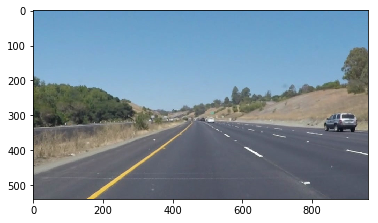

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Strategy

1. color select
2. Convert to grayscale
3. gaussian blur
4. canny edge detection
5. extrapolate or generalize lines
6. apply transformation
7. save to output file

## Output

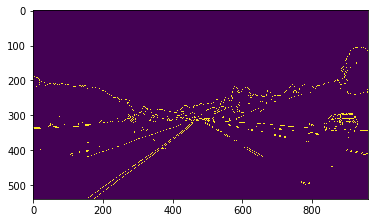

In [29]:
gray = grayscale(image)

kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)

low_threshold = 100
high_threshold = 150
canny_edges = canny(blur_gray, low_threshold, high_threshold)

plt.imshow(canny_edges)
plt.show()

In [30]:
mask1 = opening(image, 3)
smooth = blur_gray(mask1)

plt.imshow(image)
plt.show()
plt.imshow(smooth)
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [16]:
import cv2
import numpy as np

image_hsv = None   # global ;(
pixel = (20,60,80) # some stupid default

# mouse callback function
def pick_color(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pixel = image_hsv[y,x]

        #you might want to adjust the ranges(+-10, etc):
        upper =  np.array([pixel[0] + 10, pixel[1] + 10, pixel[2] + 40])
        lower =  np.array([pixel[0] - 10, pixel[1] - 10, pixel[2] - 40])
        print(pixel, lower, upper)

        image_mask = cv2.inRange(image_hsv,lower,upper)
        cv2.imshow("mask",image_mask)

def main():
    import sys
    global image_hsv, pixel # so we can use it in mouse callback

    image_src = cv2.imread('test_images/solidYellowCurve.jpg')  # pick.py my.png
    if image_src is None:
        print ("the image read is None............")
        return
    cv2.imshow("bgr",image_src)

    ## NEW ##
    cv2.namedWindow('hsv')
    cv2.setMouseCallback('hsv', pick_color)

    # now click into the hsv img , and look at values:
    image_hsv = cv2.cvtColor(image_src,cv2.COLOR_BGR2HSV)
    cv2.imshow("hsv",image_hsv)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__=='__main__':
    main()

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558631802/work/modules/highgui/src/window.cpp:632: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
